In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from PIL import Image
from tqdm import tqdm

### explor the dataset

Description of dataset:
Car Damage Detection ([CarDD](https://cardd-ustc.github.io)), the first public large-scale dataset designed for vision-based car damage detection and segmentation. CarDD contains 4,000 high-resolution car damage images (2816 train | 810 val | 374 test)  with over 9,000 well-annotated instances of six damage categories.


In [ ]:
# for example the the test train files

annFile = './drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO/annotations/instances_train2017.json'
img_dir = './drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO/train2017'

In [ ]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=5.87s)
creating index...
index created!


In [ ]:
# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

print("")
print("")
print("----------------")
print("")
# Create a dictionary between category_id and category name
category_map = dict()

for ele in list(coco.cats.values()):
    category_map.update({ele['id']:ele['name']})
    print(category_map)

Category ID: 1, Category Name: dent
Category ID: 2, Category Name: scratch
Category ID: 3, Category Name: crack
Category ID: 4, Category Name: glass shatter
Category ID: 5, Category Name: lamp broken
Category ID: 6, Category Name: tire flat


----------------

{1: 'dent'}
{1: 'dent', 2: 'scratch'}
{1: 'dent', 2: 'scratch', 3: 'crack'}
{1: 'dent', 2: 'scratch', 3: 'crack', 4: 'glass shatter'}
{1: 'dent', 2: 'scratch', 3: 'crack', 4: 'glass shatter', 5: 'lamp broken'}
{1: 'dent', 2: 'scratch', 3: 'crack', 4: 'glass shatter', 5: 'lamp broken', 6: 'tire flat'}


Image details 
 {'id': 2413, 'width': 1000, 'height': 563, 'file_name': '002413.jpg', 'license': 0}
Damages are: ['dent']


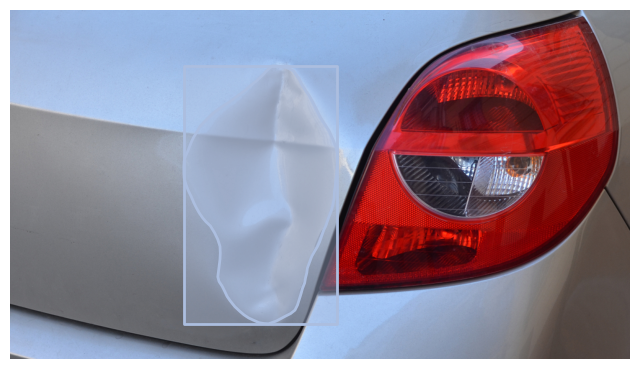

In [ ]:
# get all images containing 'dent' category, select one at random
catIds = coco.getCatIds(catNms=['dent'])
imgIds = coco.getImgIds(catIds=catIds )
random_img_id = random.choice(imgIds)

# Load the image
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)

#get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)


#Create a list of damage types in the image
damages = []
for region in anns:
    damages.append(category_map[region['category_id']])

print("Damages are:", damages)

#Plot Damages
I = io.imread(img_dir + '/' + img['file_name'])
plt.imshow(I)
plt.axis('off')
coco.showAnns(anns, draw_bbox=True )


In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.6.0+cu124
12.4


## MMDetection

In [ ]:
!pip install mmengine mmcv==2.1.0
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.4/471.4 kB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.7/452.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 25.5 MB/s eta 0:00:00
  Created wheel for mmcv: filename=mmcv-2.1.0-cp311-cp311-linux_x86_64.whl size=38291315 sha256=c6fc25222ff744046e28feefc9705d512801f6d36033f66d6ad093e2512bc5f0
  Stored in directory: /root/.cache/pip/wheels/57/22/96/9bcbfeaa838c1b705a4b2ac082539767fbcc79fa07ec01abcd
Successfully built mmcv
Cloning into 'mmdetection'...
remote: Enumerating objects: 38023, done.
remote: Total 38023 (delta 0), reused 0 (delta 0), pack-reused 38023 (from 1)
Receiving objects: 100% (38023/38023), 63.27 MiB | 15.26 MiB/s, done.
Resolving deltas: 100% (26208/26208), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Preparing metadata 

In [ ]:
# Check Pytorch installation
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print("mmdetection:",mmdet.__version__)

# Check mmcv installation
import mmcv
print("mmcv:",mmcv.__version__)

# Check mmengine installation
import mmengine
print("mmengine:",mmengine.__version__)

torch version: 2.6.0+cu124 cuda: True
mmdetection: 3.3.0
mmcv: 2.1.0
mmengine: 0.10.7


In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import cv2
import random
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import os
import seaborn as sns
from matplotlib import colors
from rich.pretty import pprint
import PIL
from PIL import Image
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
from tqdm import tqdm
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from mmengine import Config
from mmengine.runner import set_random_seed
import mmcv
from mmdet.registry import VISUALIZERS
from mmdet.apis import init_detector, inference_detector
from mmengine.structures import InstanceData

In [ ]:
%cd ..

/content


In [ ]:
content = '''
# Copyright (c) OpenMMLab. All rights reserved.
import copy
import os.path as osp
from typing import List, Union

from mmengine.fileio import get_local_path

from mmdet.registry import DATASETS
from .api_wrappers import COCO
from .base_det_dataset import BaseDetDataset


@DATASETS.register_module()
class CocoDataset(BaseDetDataset):
    """Dataset for COCO."""

    METAINFO = {
        'classes':
        ('dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat',),
        # palette is a list of color tuples, which is used for visualization.
        'palette':
        [(220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
         (0, 60, 100)]
    }
    COCOAPI = COCO
    # ann_id is unique in coco dataset.
    ANN_ID_UNIQUE = True

    def load_data_list(self) -> List[dict]:
        """Load annotations from an annotation file named as ``self.ann_file``

        Returns:
            List[dict]: A list of annotation.
        """  # noqa: E501
        with get_local_path(
                self.ann_file, backend_args=self.backend_args) as local_path:
            self.coco = self.COCOAPI(local_path)
        # The order of returned `cat_ids` will not
        # change with the order of the `classes`
        self.cat_ids = self.coco.get_cat_ids(
            cat_names=self.metainfo['classes'])
        self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
        self.cat_img_map = copy.deepcopy(self.coco.cat_img_map)

        img_ids = self.coco.get_img_ids()
        data_list = []
        total_ann_ids = []
        for img_id in img_ids:
            raw_img_info = self.coco.load_imgs([img_id])[0]
            raw_img_info['img_id'] = img_id

            ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
            raw_ann_info = self.coco.load_anns(ann_ids)
            total_ann_ids.extend(ann_ids)

            parsed_data_info = self.parse_data_info({
                'raw_ann_info':
                raw_ann_info,
                'raw_img_info':
                raw_img_info
            })
            data_list.append(parsed_data_info)
        if self.ANN_ID_UNIQUE:
            assert len(set(total_ann_ids)) == len(
                total_ann_ids
            ), f"Annotation ids in '{self.ann_file}' are not unique!"

        del self.coco

        return data_list

    def parse_data_info(self, raw_data_info: dict) -> Union[dict, List[dict]]:
        """Parse raw annotation to target format.

        Args:
            raw_data_info (dict): Raw data information load from ``ann_file``

        Returns:
            Union[dict, List[dict]]: Parsed annotation.
        """
        img_info = raw_data_info['raw_img_info']
        ann_info = raw_data_info['raw_ann_info']

        data_info = {}

        # TODO: need to change data_prefix['img'] to data_prefix['img_path']
        img_path = osp.join(self.data_prefix['img'], img_info['file_name'])
        if self.data_prefix.get('seg', None):
            seg_map_path = osp.join(
                self.data_prefix['seg'],
                img_info['file_name'].rsplit('.', 1)[0] + self.seg_map_suffix)
        else:
            seg_map_path = None
        data_info['img_path'] = img_path
        data_info['img_id'] = img_info['img_id']
        data_info['seg_map_path'] = seg_map_path
        data_info['height'] = img_info['height']
        data_info['width'] = img_info['width']

        if self.return_classes:
            data_info['text'] = self.metainfo['classes']
            data_info['caption_prompt'] = self.caption_prompt
            data_info['custom_entities'] = True

        instances = []
        for i, ann in enumerate(ann_info):
            instance = {}

            if ann.get('ignore', False):
                continue
            x1, y1, w, h = ann['bbox']
            inter_w = max(0, min(x1 + w, img_info['width']) - max(x1, 0))
            inter_h = max(0, min(y1 + h, img_info['height']) - max(y1, 0))
            if inter_w * inter_h == 0:
                continue
            if ann['area'] <= 0 or w < 1 or h < 1:
                continue
            if ann['category_id'] not in self.cat_ids:
                continue
            bbox = [x1, y1, x1 + w, y1 + h]

            if ann.get('iscrowd', False):
                instance['ignore_flag'] = 1
            else:
                instance['ignore_flag'] = 0
            instance['bbox'] = bbox
            instance['bbox_label'] = self.cat2label[ann['category_id']]

            if ann.get('segmentation', None):
                instance['mask'] = ann['segmentation']

            instances.append(instance)
        data_info['instances'] = instances
        return data_info

    def filter_data(self) -> List[dict]:
        """Filter annotations according to filter_cfg.

        Returns:
            List[dict]: Filtered results.
        """
        if self.test_mode:
            return self.data_list

        if self.filter_cfg is None:
            return self.data_list

        filter_empty_gt = self.filter_cfg.get('filter_empty_gt', False)
        min_size = self.filter_cfg.get('min_size', 0)

        # obtain images that contain annotation
        ids_with_ann = set(data_info['img_id'] for data_info in self.data_list)
        # obtain images that contain annotations of the required categories
        ids_in_cat = set()
        for i, class_id in enumerate(self.cat_ids):
            ids_in_cat |= set(self.cat_img_map[class_id])
        # merge the image id sets of the two conditions and use the merged set
        # to filter out images if self.filter_empty_gt=True
        ids_in_cat &= ids_with_ann

        valid_data_infos = []
        for i, data_info in enumerate(self.data_list):
            img_id = data_info['img_id']
            width = data_info['width']
            height = data_info['height']
            if filter_empty_gt and img_id not in ids_in_cat:
                continue
            if min(width, height) >= min_size:
                valid_data_infos.append(data_info)

        return valid_data_infos
'''
with open('./mmdetection/mmdet/datasets/coco.py', 'w') as f:
    f.write(content.strip())

### Customizing the model configuration
DCN+ involves two key techniques:
-  multi-scale learning that can be used to handle the scale diversity of objects and focal loss to enforce the model to focus on hard categories. They randomly resize the height of each training image in the range of [640, 1200] while keeping the width as 1333.
- The model will be optimized by minimizing the sum of the focal loss,the L1loss,and the cross-entropy loss. For focal loss, they use the α-balanced version to control the importance of different categories. They tried multiple combinations of α and γ and chose the best one (α=0.50 and γ=2.0) for the study of combined effect with multi-scale learning.

In [ ]:
# Below code is loading a model configuration file from MMDetection using the Config class.
cfg = Config.fromfile('mmdetection/configs/dcn/mask-rcnn_r101-dconv-c3-c5_fpn_1x_coco.py')

Below script is customizing and saving a full training configuration for an object detection + instance segmentation model using MMDetection. Let's go through it step by step.
- Load a pre-defined model config (DCN + Mask R-CNN + ResNet-101 + FPN)
- Adapt it to a custom dataset called CARDd (car damage detection)
-   Modify training pipeline, number of classes, and losses
-   Set evaluation, checkpointing, and visualization options
-    Save everything into a new config file dcn_plus_cfg.py

In [ ]:
cfg.load_from = 'https://download.openmmlab.com/mmdetection/v2.0/dcn/mask_rcnn_r101_fpn_dconv_c3-c5_1x_coco/mask_rcnn_r101_fpn_dconv_c3-c5_1x_coco_20200216-a71f5bce.pth'
cfg.data_root = './drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO'

classes = ('dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat',)
n_classes = len(classes)

# Set up working dir to save files and logs.
cfg.work_dir = './drive/MyDrive/damage_detection/v1_dcn_plus_output'

cfg.metainfo = {
    'classes': classes,
    'palette': [(220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
         (0, 60, 100)]
}

# Modify some of the model's properties
cfg.model.backbone.stage_with_dcn = (True, True, True, True)
cfg.model.roi_head.bbox_head.num_classes = n_classes
cfg.model.roi_head.mask_head.num_classes = n_classes
cfg.model.roi_head.bbox_head.loss_cls = dict(type='FocalLoss', use_sigmoid=True, gamma=2.0, alpha=0.5, loss_weight=1.0)

cfg.train_dataloader.dataset.ann_file = 'annotations/instances_train2017.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train2017/'

cfg.val_dataloader.dataset.ann_file = 'annotations/instances_val2017.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val2017/'

cfg.test_dataloader.dataset.ann_file = 'annotations/instances_test2017.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test2017/'

cfg.val_evaluator = {'type': 'CocoMetric',
 'ann_file': '/content/drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO/annotations/instances_val2017.json',
 'metric': ['bbox','segm'],
 'classwise': True,
 'format_only': False,
 'backend_args': None}

cfg.test_evaluator = {'type': 'CocoMetric',
 'ann_file': '/content/drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO/annotations/instances_test2017.json',
 'metric': ['bbox','segm'],
 'classwise': True,
 'format_only': False,
 'backend_args': None}

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=[(1333, 640), (1333, 1200)], multiscale_mode='range', keep_ratio=False, backend='pillow'),
    dict(type='PackDetInputs')
]

# Schedule the training
cfg.train_cfg.max_epochs = 24
cfg.optim_wrapper.optimizer.lr = 0.005
cfg.param_scheduler[1] = dict(type= 'MultiStepLR', begin= 0, end= 24, by_epoch= True,
                              milestones= [16, 22], gamma= 0.1)

# We can set the evaluation interval
cfg.train_cfg.val_interval = 1

# We can set the checkpoint saving interval
cfg.default_hooks.checkpoint.interval = 1
cfg.default_hooks.logger.interval = 50

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------

config= './drive/MyDrive/damage_detection/v1_dcn_plus_cfg.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

# Train
- To train using 1 gpu run:!python mmdetection/tools/train.py dcn_plus_cfg.py
- To perform distributed training using 2 gpus run the following:

In [ ]:
!bash mmdetection/tools/dist_train.sh './drive/MyDrive/damage_detection/v1_dcn_plus_cfg.py' 1

/usr/local/lib/python3.11/dist-packages/torch/distributed/launch.py:208: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use-env is set by default in torchrun.
If your script expects `--local-rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  main()
/usr/local/lib/python3.11/dist-packages/mmengine/utils/dl_utils/setup_env.py:46: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mmengine/utils/dl_utils/setup_env.py:56: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, pl

### Plots

In [ ]:
!python mmdetection/tools/analysis_tools/analyze_logs.py plot_curve drive/MyDrive/damage_detection/v1_dcn_plus_output/20250724_175825/vis_data/scalars.json --keys loss --out drive/MyDrive/damage_detection/v1_dcn_plus_output/loss.jpg --legend loss --title 'total loss'

plot curve of drive/MyDrive/damage_detection/v1_dcn_plus_output/20250724_175825/vis_data/scalars.json, metric is loss
save curve to: drive/MyDrive/damage_detection/v1_dcn_plus_output/loss.jpg


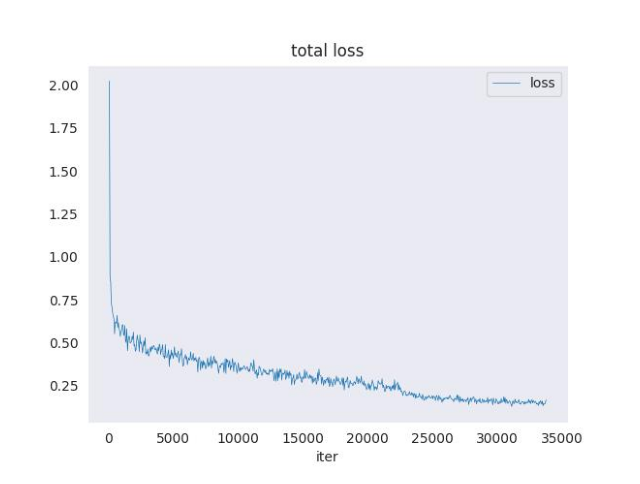

In [ ]:
cm = mmcv.imread('drive/MyDrive/damage_detection/v1_dcn_plus_output/loss.jpg')
cm = mmcv.imconvert(cm, 'bgr', 'rgb')
plt.imshow(cm)
plt.axis('off')
plt.show()

In [ ]:
!python mmdetection/tools/analysis_tools/analyze_logs.py plot_curve drive/MyDrive/damage_detection/v1_dcn_plus_output/20250724_175825/vis_data/scalars.json --keys segm_mAP segm_mAP_50 segm_mAP_75 --out drive/MyDrive/damage_detection/v1_dcn_plus_output/segm_mAP.jpg --legend mAP mAP_50 mAP_75 --title 'segmentation mAP'

plot curve of drive/MyDrive/damage_detection/v1_dcn_plus_output/20250724_175825/vis_data/scalars.json, metric is segm_mAP
plot curve of drive/MyDrive/damage_detection/v1_dcn_plus_output/20250724_175825/vis_data/scalars.json, metric is segm_mAP_50
plot curve of drive/MyDrive/damage_detection/v1_dcn_plus_output/20250724_175825/vis_data/scalars.json, metric is segm_mAP_75
save curve to: drive/MyDrive/damage_detection/v1_dcn_plus_output/segm_mAP.jpg


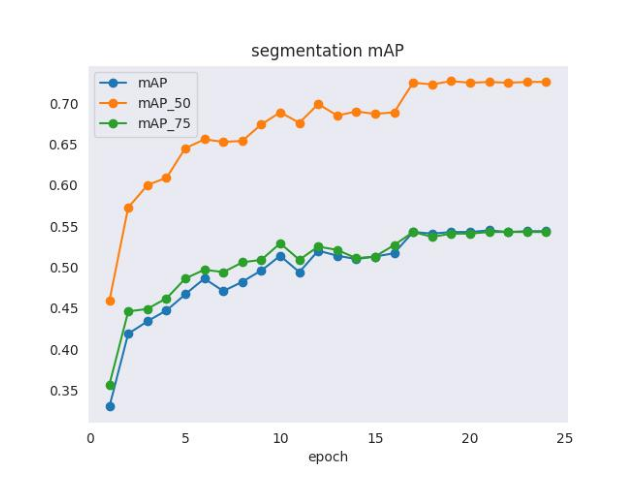

In [ ]:
cm = mmcv.imread('drive/MyDrive/damage_detection/v1_dcn_plus_output/segm_mAP.jpg')
cm = mmcv.imconvert(cm, 'bgr', 'rgb')
plt.imshow(cm)
plt.axis('off')
plt.show()

### test

In [ ]:
from mmengine.runner import load_checkpoint

# Load full checkpoint
checkpoint = torch.load('drive/MyDrive/damage_detection/v1_dcn_plus_output/epoch_24.pth', weights_only=False)

# Save only model weights
torch.save(checkpoint['state_dict'], 'drive/MyDrive/damage_detection/v1_dcn_plus_output/epoch_24_weights_only.pth')


In [ ]:
!python mmdetection/tools/test.py \
 drive/MyDrive/damage_detection/v1_dcn_plus_cfg.py \
 drive/MyDrive/damage_detection/v1_dcn_plus_output/epoch_24_weights_only.pth \
 --out drive/MyDrive/damage_detection/v1_dcn_plus_output/predictions.pkl

2025-07-24 21:29:49.908532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753392589.930030   69256 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753392589.936426   69256 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
07/24 21:29:53 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 190522016
    GPU 0: NVIDIA A100-SXM4-40GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gc

In [ ]:
# edited the confusion_matrix.py to have "figsize=( num_classes, num_classes ))"" for better image output

!python mmdetection/tools/analysis_tools/confusion_matrix.py drive/MyDrive/damage_detection/v1_dcn_plus_cfg.py drive/MyDrive/damage_detection/v1_dcn_plus_output/predictions.pkl drive/MyDrive/damage_detection/v1_dcn_plus_output --show

2025-07-24 21:32:45.191508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753392765.212122   70034 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753392765.218477   70034 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 374/374, 2088.7 task/s, elapsed: 0s, ETA:     0sFigure(700x700)


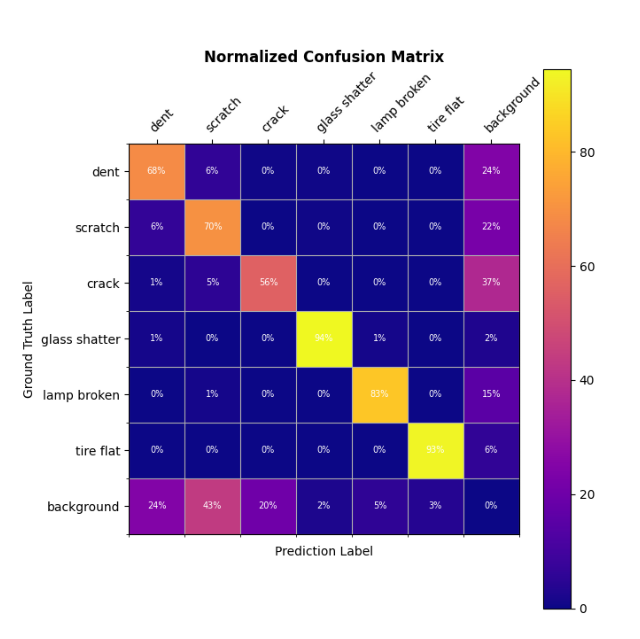

In [ ]:
cm = mmcv.imread('drive/MyDrive/damage_detection/v1_dcn_plus_output/confusion_matrix.png')
cm = mmcv.imconvert(cm, 'bgr', 'rgb')
plt.imshow(cm)
plt.axis('off')
plt.show()

In [ ]:
# Replace this
# per_label_sums = confusion_matrix.sum(axis=1)[:, np.newaxis]
# confusion_matrix = \
#     confusion_matrix.astype(np.float32) / per_label_sums * 100

# With this
# confusion_matrix = confusion_matrix.astype(np.int32)

# And update the annotation text (inside the double for-loop)
# From this
# '{}%'

# To this
# '{}'

# also make  title='Confusion Matrix'

# save image as confusion_matrix2.png

# chnages in onfusion_matrix.py



!python mmdetection/tools/analysis_tools/confusion_matrix.py drive/MyDrive/damage_detection/v1_dcn_plus_cfg.py drive/MyDrive/damage_detection/v1_dcn_plus_output/predictions.pkl drive/MyDrive/damage_detection/v1_dcn_plus_output --show

2025-07-24 21:34:48.642842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753392888.664613   70621 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753392888.671098   70621 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 374/374, 2063.2 task/s, elapsed: 0s, ETA:     0sFigure(700x700)


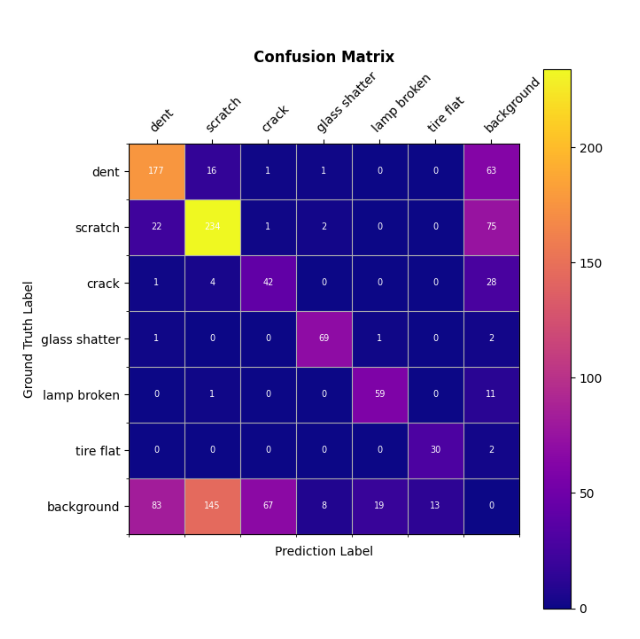

In [ ]:
cm = mmcv.imread('drive/MyDrive/damage_detection/v1_dcn_plus_output/confusion_matrix2.png')
cm = mmcv.imconvert(cm, 'bgr', 'rgb')
plt.imshow(cm)
plt.axis('off')
plt.show()

### Test for time

In [ ]:
!python mmdetection/tools/analysis_tools/benchmark.py \
    drive/MyDrive/damage_detection/v1_dcn_plus_cfg.py \
    --checkpoint drive/MyDrive/damage_detection/v1_dcn_plus_output/epoch_24_weights_only.pth \
    --task inference \
    --log-interval 100 \
    --dataset-type test

07/24 21:35:14 - mmengine - INFO - before build: 
07/24 21:35:14 - mmengine - INFO - (GB) mem_used: 3.18 | uss: 0.43 | pss: 0.57 | total_proc: 1
2025-07-24 21:35:15.961994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753392915.983482   70780 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753392915.989936   70780 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loads checkpoint by local backend from path: drive/MyDrive/damage_detection/v1_dcn_plus_output/epoch_24_weights_only.pth
07/24 21:35:20 - mmengine - INFO - DeformConv2dPack backbone.layer1.0.conv2 is upgraded to version 2.
07/24 21:35:20 - mmengine - INFO - DeformConv2dPack backbone.layer1.1

## images test 
- this is used in the "all_models_images" to test all models togather

In [ ]:
def inference_on_image(img_path, model, threshold=0.5):
    # Load and convert image
    img = mmcv.imread(img_path)
    img = mmcv.imconvert(img, 'bgr', 'rgb')

    visualizer = VISUALIZERS.build(model.cfg.visualizer)
    visualizer.dataset_meta = {
        'classes': ('dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat'),
        'palette': [(220, 20, 60), (119, 11, 32), (0, 0, 142),
                    (0, 0, 230), (106, 0, 228), (0, 60, 100)]
    }

    result = inference_detector(model, img)
    predictions = result.pred_instances

    # Filter predictions by threshold
    indices = predictions.scores >= threshold
    filtered_masks = predictions.masks[indices]
    filtered_bboxes = predictions.bboxes[indices]
    filtered_labels = predictions.labels[indices]
    filtered_scores = predictions.scores[indices]

    filtered_predictions = InstanceData(
        masks=filtered_masks,
        bboxes=filtered_bboxes,
        labels=filtered_labels,
        scores=filtered_scores
    )
    result.pred_instances = filtered_predictions

    # visualizer
    visualizer.add_datasample(
        'result',
        img,
        data_sample=result,
        draw_gt=False,
        show=False
    )
    frame = visualizer.get_image()

    # damage info
    classes = visualizer.dataset_meta['classes']
    label_counts = {}
    for label in filtered_labels:
        class_name = classes[label]
        label_counts[class_name] = label_counts.get(class_name, 0) + 1

    print(f"\nTotal Damages Detected: {len(filtered_labels)}")
    for damage_type, count in label_counts.items():
        print(f"- {damage_type}: {count}")

    # original img and result img side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(frame)
    axs[1].set_title("Detected Damages")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
config_file = 'drive/MyDrive/damage_detection/v1_dcn_plus_cfg.py'

checkpoint_file = 'drive/MyDrive/damage_detection/v1_dcn_plus_output/epoch_24_weights_only.pth'
# Build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device= 0)

Loads checkpoint by local backend from path: drive/MyDrive/damage_detection/v1_dcn_plus_output/epoch_24_weights_only.pth
07/24 21:35:51 - mmengine - INFO - DeformConv2dPack backbone.layer1.0.conv2 is upgraded to version 2.
07/24 21:35:51 - mmengine - INFO - DeformConv2dPack backbone.layer1.1.conv2 is upgraded to version 2.
07/24 21:35:51 - mmengine - INFO - DeformConv2dPack backbone.layer1.2.conv2 is upgraded to version 2.
07/24 21:35:51 - mmengine - INFO - DeformConv2dPack backbone.layer2.0.conv2 is upgraded to version 2.
07/24 21:35:51 - mmengine - INFO - DeformConv2dPack backbone.layer2.1.conv2 is upgraded to version 2.
07/24 21:35:51 - mmengine - INFO - DeformConv2dPack backbone.layer2.2.conv2 is upgraded to version 2.
07/24 21:35:51 - mmengine - INFO - DeformConv2dPack backbone.layer2.3.conv2 is upgraded to version 2.
07/24 21:35:51 - mmengine - INFO - DeformConv2dPack backbone.layer3.0.conv2 is upgraded to version 2.
07/24 21:35:51 - mmengine - INFO - DeformConv2dPack backbone.la

/content/mmdetection/mmdet/apis/inference.py:90: UserWarning: dataset_meta or class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn(


In [ ]:
warnings.filterwarnings("ignore", category=UserWarning) # Hide warning when plotting the prediction